# Probit Model (EP)

In [52]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`


Status `~/.julia/dev/RxInfer/examples/Project.toml`
  [b4ee3484] BayesBase v1.2.1
  [6e4b80f9] BenchmarkTools v1.5.0
  [336ed68f] CSV v0.10.13
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.107
  [62312e5e] ExponentialFamily v1.4.1
⌃ [587475ba] Flux v0.14.11
  [38e38edf] GLM v1.9.0
  [b3f8163a] GraphPPL v4.0.0 `https://github.com/ReactiveBayes/GraphPPL.jl#dev-4.0.0-examples`
  [34004b35] HypergeometricFunctions v0.3.23
  [7073ff75] IJulia v1.24.2
  [4138dd39] JLD v0.13.5
  [b964fa9f] LaTeXStrings v1.3.1
  [429524aa] Optim v1.9.4
⌃ [3bd65402] Optimisers v0.2.20
  [d96e819e] Parameters v0.12.3
  [91a5bcdd] Plots v1.40.3
  [92933f4c] ProgressMeter v1.10.0
  [a194aa59] ReactiveMP v3.13.3 `https://github.com/ReactiveBayes/ReactiveMP.jl#dev-4.0.0-examples`
  [37e2e3b7] ReverseDiff v1.15.1
  [df971d30] Rocket v1.7.4
  [86711068] RxInfer v2.16.1 `https://github.com/ReactiveBayes/RxInfer.jl#dev-4.0.0-examples`
  [276daf66] SpecialFunctions v2.3.1
  [860ef19b] StableRNGs v1.0.1


## Estimation of pollutant 

Mortality $y_t$ of fishs in a lake is observed over time. Mortality rate $\text{Ber}(\Phi(x_t))$ is linked to the level of pollutant $x_t$ in the lake according to the probit model (see below). The municipality wants to keep track of the pollution. To do so, the level of pollutant in the lake is tracked over time through observations of the fishs.

## Objective 

Probit model aims to infer a random proces value from noisy binary observations of it.
`RxInfer` comes with support for expectation propagation (EP). In this demo we illustrate EP in the context of state-estimation in a linear state-space model that combines a Gaussian state-evolution model with a discrete observation model. Here, the probit function links continuous variable $x_t$ with the discrete variable $y_t$. The model is defined as:

$$\begin{aligned}
    u &= 0.1 \\
    x_0 &\sim \mathcal{N}(0, 100) \\
    x_t &\sim \mathcal{N}(x_{t-1}+ u, 0.01) \\
    y_t &\sim \mathrm{Ber}(\Phi(x_t))
\end{aligned}$$

## Import packages

In [4]:
using RxInfer, GraphPPL,StableRNGs, Random, Plots, Distributions
using StatsFuns: normcdf

##  Data generation

In [40]:
function generate_data(nr_samples::Int64; seed = 123)
    
    rng = StableRNG(seed)
    
    # hyper parameters
    u = 0.1

    # allocate space for data
    data_x = zeros(nr_samples + 1)
    data_y = zeros(nr_samples)
    
    # initialize data
    data_x[1] = -2
    
    # generate data
    for k in eachindex(data_y)
        
        # calculate new x
        data_x[k+1] = data_x[k] + u + sqrt(0.01)*randn(rng)
        
        # calculate y
        data_y[k] = normcdf(data_x[k+1]) > rand(rng)
        
    end
    
    # return data
    return data_x, data_y
    
end;

In [41]:
n = 40

40

In [42]:
data_x, data_y = generate_data(n);

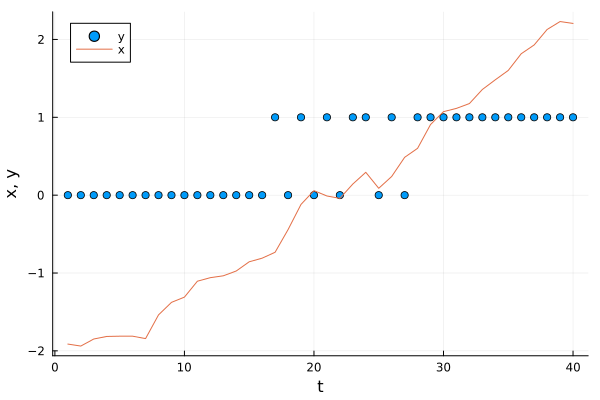

In [43]:
p = plot(xlabel = "t", ylabel = "x, y")
p = scatter!(p, data_y, label = "y")
p = plot!(p, data_x[2:end], label = "x")

## Model specification

In [47]:
@model function probit_model(y, prior_x)
    
    # specify uninformative prior
    x_prev ~ prior_x
    
    # create model 
    for k in eachindex(y)
        x[k] ~ Normal(mean = x_prev + 0.1, precision = 100)
        y[k] ~ Probit(x[k]) where {
            # Probit node by default uses RequireMessage pipeline with vague(NormalMeanPrecision) message as initial value for `in` edge
            # To change initial value user may specify it manually, like. Changes to the initial message may improve stability in some situations
            dependencies = RequireMessageFunctionalDependencies(in = NormalMeanPrecision(0.0, 0.01))
        }
        x_prev = x[k]
    end
    
end;

### Probit Node

Probit node needs an initialisation of the 'in' message because of this computation methodology. The input message is not directly calculated. First the marginal $q(in)$ is computed and then the output message, this using the margianalisation formula. 

$$\overrightarrow{\mu}(x) \overleftarrow{\mu}(x) = q(x)$$

Consequently an initial message $\overleftarrow{\mu}(in)$ is needed to start iterate. It can be speficied as in the above example. Otherwise `RxInfer` will initiate it at a default value.

## Inference

In [48]:
result = infer(
    model = probit_model(prior_x=Normal(0.0, 100.0)), 
    data  = (y = data_y, ), 
    iterations = 5, 
    returnvars = (x = KeepLast(),),
    free_energy  = true
)

Inference results:
  Posteriors       | available for (x)
  Free Energy:     | Real[25.6698, 18.0157, 17.9199, 17.9194, 17.9194]


## Results

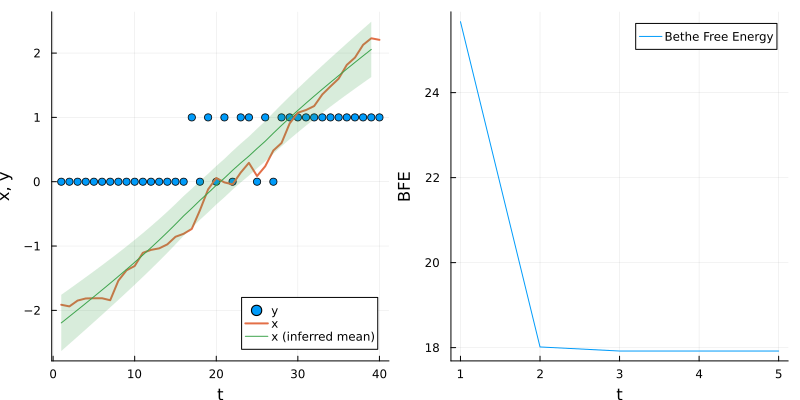

In [50]:
mx = result.posteriors[:x]

p = plot(xlabel = "t", ylabel = "x, y", legend = :bottomright)
p = scatter!(p, data_y, label = "y")
p = plot!(p, data_x[2:end], label = "x", lw = 2)
p = plot!(mean.(mx)[2:end], ribbon = std.(mx)[2:end], fillalpha = 0.2, label="x (inferred mean)")

f = plot(xlabel = "t", ylabel = "BFE")
f = plot!(result.free_energy, label = "Bethe Free Energy")

plot(p, f, size = (800, 400))